In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter # Para formatear los ejes

from sklearn.model_selection import KFold # Para validar

In [2]:
train = pd.read_csv('data/train_limpio.csv')
#test = pd.read_csv('data/test_limpio.csv')

In [3]:
X = train.drop(columns=['precio'])
y = train['precio']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(180000, 70) (180000,)
(60000, 70) (60000,)


# Random Forest Classifier

In [6]:
%%time
r_f_regressor = RandomForestRegressor(n_estimators=100, n_jobs=4)
r_f_regressor.fit(X_train, y_train)

CPU times: user 3min 31s, sys: 1.15 s, total: 3min 33s
Wall time: 53.5 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [7]:
prediction = r_f_regressor.predict(X_test)
mean_absolute_error(y_test, prediction)

677238.079521243

In [8]:
y_test.shape

(60000,)

In [9]:
prediction.shape

(60000,)

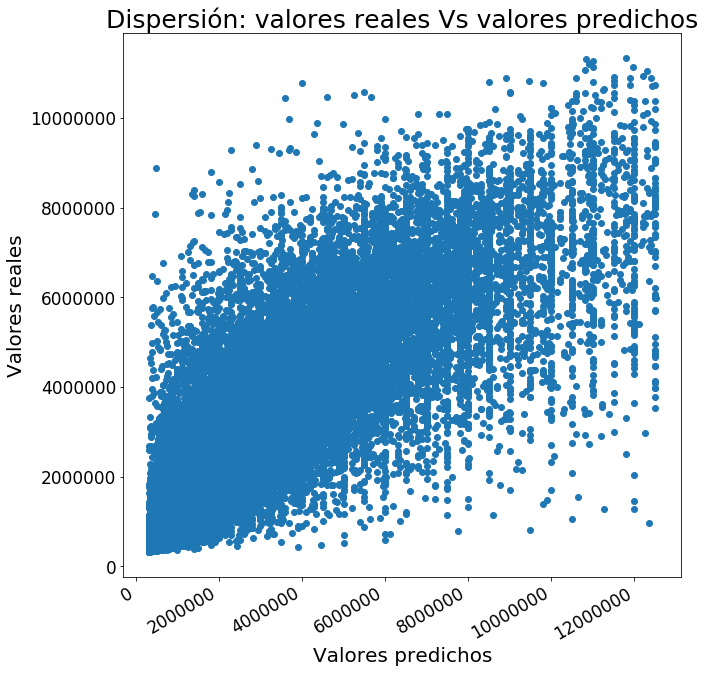

In [10]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, prediction)
plt.title('Dispersión: valores reales Vs valores predichos', fontsize = 25)
plt.ylabel('Valores reales', fontsize = 20)
plt.xlabel('Valores predichos', fontsize = 20)
plt.xticks(rotation = 30, fontsize = 17, ha = 'right')
plt.yticks(fontsize = 17)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.show()

In [11]:
%%time
transf = True
kfold = KFold(5, True, 42)
for i, (train_index, test_index) in enumerate(kfold.split(X)):
    # Se parte el dataset en dos, train y test, con el train entreno
    # y con el test evaluo como predice mi algoritmo
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    if transf:
        y_train = np.log(y_train)
    # Me creo una instancia del modelo y luego lo entreno con los datos(con fit(X,y))
    reg_t = RandomForestRegressor(n_estimators=100, n_jobs=4)
    reg_t.fit(X_train, y_train)
    predicciones_t = reg_t.predict(X_test)
    if transf:
        predicciones_t = np.exp(predicciones_t)

    # Me fijo como me da el resultado
    print(f"Error de fold N°{i} es : {round(mean_absolute_error(y_test, predicciones_t), 2)}")

Error de fold N°0 es : 668369.3004526494
Error de fold N°1 es : 659800.3286313737
Error de fold N°2 es : 664558.9755389584
Error de fold N°3 es : 663481.932835373
Error de fold N°4 es : 659453.2563977904
CPU times: user 19min 50s, sys: 4.57 s, total: 19min 55s
Wall time: 5min 1s


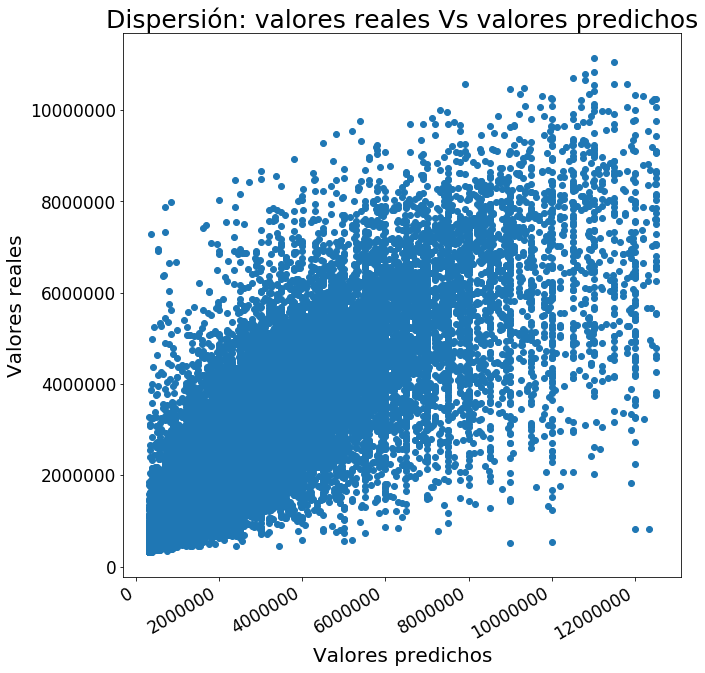

In [12]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, predicciones_t)
plt.title('Dispersión: valores reales Vs valores predichos', fontsize = 25)
plt.ylabel('Valores reales', fontsize = 20)
plt.xlabel('Valores predichos', fontsize = 20)
plt.xticks(rotation = 30, fontsize = 17, ha = 'right')
plt.yticks(fontsize = 17)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.show()